# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as sts
from IPython.display import clear_output

In [2]:
## Single cell and TCR packages
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import scirpy 

# data load from GEO and tar decompression

Here we download public data of matched single cell RNA and TCR sequencing generated on the 10x Genomics platform. can be aqcuired from ["GEO GSE176021"](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176021), where it is stored in zipped .tar archives, so it needs to be decompressed before usage. Sequencing results are aquired from anti-PD-1 treated lung cancer patients

In [3]:
! mkdir data
%cd ./data

/home/fgrigoriev/proj/sc/data


In [4]:
# MD043-006
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352972/suppl/GSM5352972%5FMD043%2D006%5Fnormal%5F1%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352972/suppl/GSM5352972%5FMD043%2D006%5Fnormal%5F1%2Evdj%2Etar%2Egz
    
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352973/suppl/GSM5352973%5FMD043%2D006%5Ftumor%5F1%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352973/suppl/GSM5352973%5FMD043%2D006%5Ftumor%5F1%2Evdj%2Etar%2Egz
    
# MD043-008
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352948/suppl/GSM5352948%5FMD043%2D008%5Fnormal%5F1%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352948/suppl/GSM5352948%5FMD043%2D008%5Fnormal%5F1%2Evdj%2Etar%2Egz
    
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352947/suppl/GSM5352947%5FMD043%2D008%5Ftumor%5F1%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352947/suppl/GSM5352947%5FMD043%2D008%5Ftumor%5F1%2Evdj%2Etar%2Egz
    
# MD043-011   
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352894/suppl/GSM5352894%5FMD043%2D011%5Fnormal%5F1%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352894/suppl/GSM5352894%5FMD043%2D011%5Fnormal%5F1%2Evdj%2Etar%2Egz
    
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352899/suppl/GSM5352899%5FMD043%2D011%5Ftumor%5F2%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352899/suppl/GSM5352899%5FMD043%2D011%5Ftumor%5F2%2Evdj%2Etar%2Egz
    
# MD01-010
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352887/suppl/GSM5352887%5FMD01%2D010%5Fnormal%5F1%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352887/suppl/GSM5352887%5FMD01%2D010%5Fnormal%5F1%2Evdj%2Etar%2Egz
    
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352888/suppl/GSM5352888%5FMD01%2D010%5Ftumor%5F1%2Etar%2Egz
! wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5352nnn/GSM5352888/suppl/GSM5352888%5FMD01%2D010%5Ftumor%5F1%2Evdj%2Etar%2Egz
    
clear_output()

In [5]:
! gzip -d ../data1/*
clear_output()

In [6]:
tars = ! ls | grep  .tar

for file in tars:
    ! tar -xvf $file -C ~/proj/sc/data1

clear_output()

# Single cell RNAseq

## ann data concatenation

In [7]:
%%capture --no-display

dirs = ! ls -d */ | grep -v -e 'vdj' -e data
adatas = []

for path in dirs:
    adata = sc.read_10x_mtx(path)
    adata.obs['sample'] = path
    adata.obs['pat'] = path.split('_')[0]
    adata.obs['tumor'] = 'tumor' in path
    adatas.append(adata)
    
adata = adatas[0].concatenate(adatas[1:])

# Mapping response information from geo
response_dict = {
    'MD01-010': 'MPR',
    'MD043-006': 'Non-MPR',
    'MD043-008': 'MPR',
    'MD043-011': 'Non-MPR',
    'NY016-007': 'Non-MPR',
    'NY016-025': 'MPR'
}

## QC filtering: mito, ribo, doublets, gene counts

Before our trnscriptomal analsis e have to filter out low quality results. High proportions of mitochondrial genes are indicative of poor-quality cells, possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [8]:
import re
ribosomal_mask = re.compile("^RP[SL][0-9]") 
adata.var_names.map(lambda x: ribosomal_mask.match(x)).notna().sum()

100

In [9]:
import re

ribosomal_mask = re.compile("^RP[SL][0-9]") 
adata.var["rp"]= adata.var_names.map(lambda x: ribosomal_mask.match(x)).notna()
adata.var["rp"].value_counts()
adata.var["mt"] = adata.var_names.str.startswith("MT-")

In [10]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'rp'], percent_top=None, log1p=False, inplace=True) # Подсчитываем QC
adata.obs.head()

sample       pat  tumor batch  \
AAACCTGAGACTAAGT-1-0  MD01-010_normal_1/  MD01-010  False     0   
AAACCTGTCTCTAAGG-1-0  MD01-010_normal_1/  MD01-010  False     0   
AAACGGGAGTTGTAGA-1-0  MD01-010_normal_1/  MD01-010  False     0   
AAACGGGCATAAAGGT-1-0  MD01-010_normal_1/  MD01-010  False     0   
AAACGGGCATGTAGTC-1-0  MD01-010_normal_1/  MD01-010  False     0   

                      n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGACTAAGT-1-0               1583        4355.0            273.0   
AAACCTGTCTCTAAGG-1-0               1221        2874.0            189.0   
AAACGGGAGTTGTAGA-1-0               1429        4736.0            295.0   
AAACGGGCATAAAGGT-1-0               1290        3280.0            209.0   
AAACGGGCATGTAGTC-1-0               1269        4218.0            234.0   

                      pct_counts_mt  total_counts_rp  pct_counts_rp  
AAACCTGAGACTAAGT-1-0       6.268657           1161.0      26.659012  
AAACCTGTCTCTAAGG-1-0       6.576200            557.0      19.380655  
AAACGGGAGTTGTAGA-1-0       6.228885           1649.0      34.818413  
AAACGGGCATAAAGGT-1-0       6.371951            687.0      20.945122  
AAACGGGCATGTAGTC-1-0       5.547653           1604.0      38.027500

In [11]:
def plot_qc(adata):
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(55, 10)) 

    sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1})
    axs[0].set_xlabel("Number of UMIs per cell")
    axs[0].set_ylabel("Number of cells")
    axs[0].set_title("total counts")

    sns.distplot(adata.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
    axs[1].set_xlabel("Number of expressed genes per cell")
    axs[1].set_ylabel("Number of cells")
    axs[1].set_title("n_genes_by_counts")

    sns.distplot(adata.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
    axs[2].set_xlabel("Persentage of mitochondrial expression per cell")
    axs[2].set_ylabel("Number of cells")
    axs[2].set_title("pct_counts_mt")

    sns.distplot(adata.obs["pct_counts_rp"], kde=False, ax=axs[3], hist_kws={"alpha":1})
    axs[3].set_xlabel("Persentage of ribosomal expression per cell")
    axs[3].set_ylabel("Number of cells")
    axs[3].set_title("pct_counts_rp")

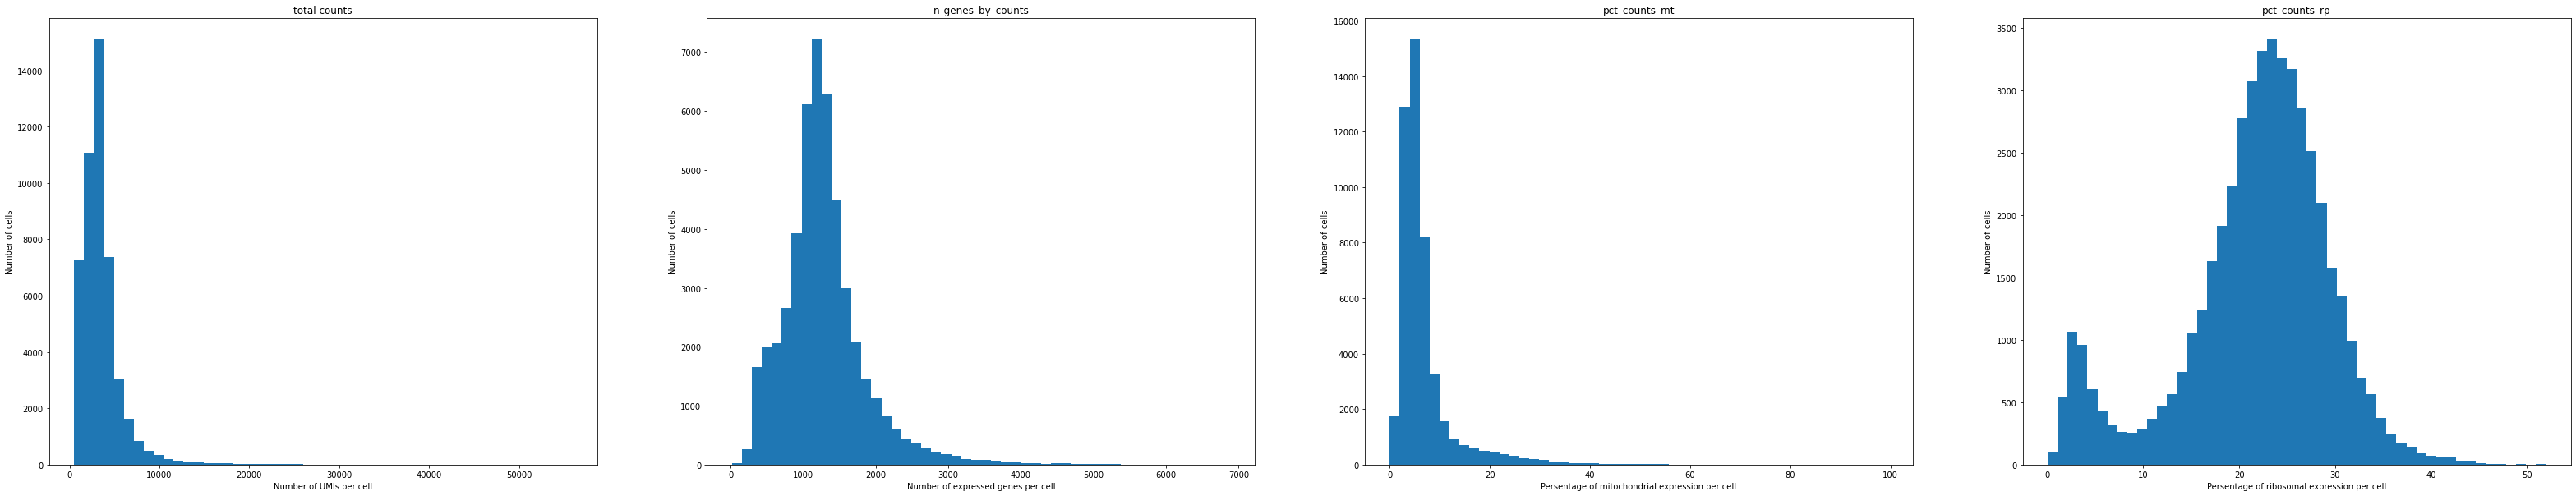

In [14]:
import warnings 
warnings.filterwarnings('ignore')
plot_qc(adata)

In [15]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, header=[1])

In [16]:
adata_filtered = adata.copy()

adata_filtered = adata_filtered[adata_filtered.obs['total_counts'] > 100]
adata_filtered = adata_filtered[adata_filtered.obs['pct_counts_mt'] < 10]
adata_filtered = adata_filtered[adata_filtered.obs['pct_counts_rp'] > 10] 
adata_filtered = adata_filtered[adata_filtered.obs['n_genes_by_counts'] > 250] 
adata_filtered = adata_filtered[adata_filtered.obs['n_genes_by_counts'] < 1149 + 3 * 550] 

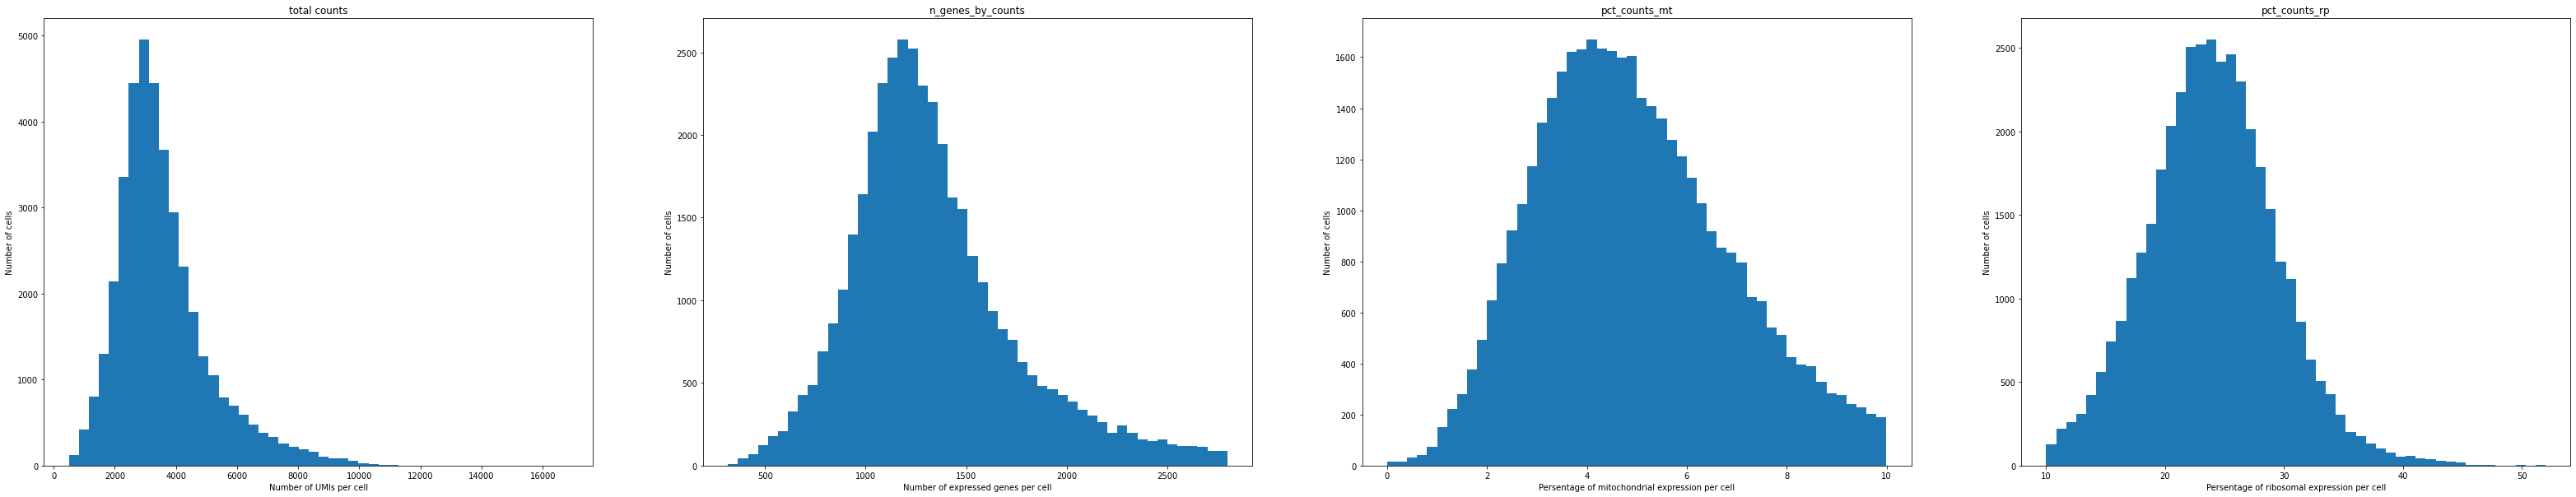

In [17]:
plot_qc(adata_filtered)

## getting rid of TCR, ribosomal and IG genes

TCR, immunoglobulin and mitochondrial genes, as well as features that constitute Interferon I mediated pathway, were excluded from clustering to make sure that clustering result will not be influenced by their variability.

In [18]:
genes = pd.Series(adata_filtered.var.index)
list(genes[genes.apply(lambda x: x.startswith('TRA') | x.startswith('TRB') | x.startswith('TRC'))].values)[:4]

['TRAPPC3', 'TRABD2B', 'TRAF3IP3', 'TRAF5']

In [19]:
tcr_mask = re.compile("^TR[ABDG][VDJ][0-9]*") 
tcr_mask = adata_filtered.var_names.map(lambda x: tcr_mask.match(x)).notna()
adata_filtered = adata_filtered[:, ~tcr_mask]

In [20]:
rb_mask = re.compile("^RP.*") 
rb_mask = adata_filtered.var_names.map(lambda x: rb_mask.match(x)).notna()
adata_filtered = adata_filtered[:, ~rb_mask]

In [21]:
adata_filtered = adata_filtered[:, ~adata_filtered.var_names.isin(ribo_genes.values.flatten())]

In [22]:
ifnI_genes = 'Adar Cactin Cdc37 Cnot7 Dcst1 Fadd Hdac4 Ifih1 Ifitm1 Ifitm2 Ifitm3 Ifitm3 Ifitm6 Ifitm7 Ifna1 Ifnar1 Ifnar1 Ifnar1 Ifnar1 Ifnar1 Ifnar2 Ifnar2 Ifnb1 Ifnb1 Ikbke Ikbke Irak1 Irf3 Irf3 Irf7 Irf7 Isg15 Jak1 Lsm14a Mavs Mettl3 Mmp12 Mmp12 Mul1 Myd88 Nlrc5 Nlrc5 Nlrc5 Nlrc5 Oas1a Oas1a Oas1b Oas1b Oas1c Oas1c Oas1d Oas1d Oas1e Oas1e Oas1f Oas1f Oas1g Oas1g Oas1h Oas1h Oas2 Oas3 Ptpn2 Ptpn2 Ptpn2 Rbm47 Rfpl4b Rnf185 Samhd1 Samhd1 Stat1 Stat1 Stat1 Stat1 Stat2 Stat2 Stat2 Stat2 Stat2 Stat2 Sting1 Sting1 Tbk1 Trex1 Trex1 Trim6 Trim6 Trim41 Trim56 Trim56 Trim56 Trim65 Ttll12 Tyk2 Ube2k Usp27x Usp29 Wnt5a Ythdf2 Ythdf3 Zbp1 Zbp1'.split()
ifnI_genes = list(map(lambda x: x.upper(), ifnI_genes))

adata_filtered = adata_filtered[:, ~adata_filtered.var_names.isin(ifnI_genes)]

In [23]:
mt_mask = re.compile("^MT-.*") 
mt_mask = adata_filtered.var_names.map(lambda x: mt_mask.match(x)).notna()
adata_filtered.var_names[mt_mask]

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object')

In [24]:
ig_genes = 'IGBP1 IGBP1-AS1 IGBP1-AS2 IGBP1P1 IGBP1P3 IGBP1P4 IGBP1P5 IGHA1 IGHA2 IGHD IGHD1-1 IGHD1-14 IGHD1-20 IGHD1-26 IGHD1-7 IGHD1OR15-1A IGHD1OR15-1B IGHD2-15 IGHD2-2 IGHD2-21 IGHD2-8 IGHD2OR15-2A IGHD2OR15-2B IGHD3-10 IGHD3-16 IGHD3-22 IGHD3-3 IGHD3-9 IGHD3OR15-3A IGHD3OR15-3B IGHD4-11 IGHD4-17 IGHD4-23 IGHD4-4 IGHD4OR15-4A IGHD4OR15-4B IGHD5-12 IGHD5-18 IGHD5-24 IGHD5-5 IGHD5OR15-5A IGHD5OR15-5B IGHD6-13 IGHD6-19 IGHD6-25 IGHD6-6 IGHD7-27 IGHE IGHEP1 IGHEP2 IGHG1 IGHG2 IGHG3 IGHG4 IGHGP IGHJ1 IGHJ1P IGHJ2 IGHJ2P IGHJ3 IGHJ3P IGHJ4 IGHJ5 IGHJ6 IGHM IGHMBP2 IGHV1-12 IGHV1-14 IGHV1-17 IGHV1-18 IGHV1-2 IGHV1-24 IGHV1-3 IGHV1-45 IGHV1-46 IGHV1-58 IGHV1-67 IGHV1-68 IGHV1-69 IGHV1-8 IGHV1OR15-1 IGHV1OR15-2 IGHV1OR15-3 IGHV1OR15-4 IGHV1OR15-6 IGHV1OR15-9 IGHV1OR16-1 IGHV1OR16-2 IGHV1OR16-3 IGHV1OR16-4 IGHV1OR21-1 IGHV2-10 IGHV2-26 IGHV2-5 IGHV2-70 IGHV2OR16-5 IGHV3-11 IGHV3-13 IGHV3-15 IGHV3-16 IGHV3-19 IGHV3-20 IGHV3-21 IGHV3-22 IGHV3-23 IGHV3-25 IGHV3-29 IGHV3-30 IGHV3-30-2 IGHV3-32 IGHV3-33 IGHV3-33-2 IGHV3-35 IGHV3-36 IGHV3-37 IGHV3-38 IGHV3-41 IGHV3-42 IGHV3-43 IGHV3-47 IGHV3-48 IGHV3-49 IGHV3-50 IGHV3-52 IGHV3-53 IGHV3-54 IGHV3-57 IGHV3-6 IGHV3-60 IGHV3-62 IGHV3-63 IGHV3-64 IGHV3-65 IGHV3-66 IGHV3-7 IGHV3-71 IGHV3-72 IGHV3-73 IGHV3-74 IGHV3-75 IGHV3-76 IGHV3-79 IGHV3-9 IGHV3OR15-7 IGHV3OR16-10 IGHV3OR16-11 IGHV3OR16-12 IGHV3OR16-13 IGHV3OR16-15 IGHV3OR16-6 IGHV3OR16-7 IGHV3OR16-8 IGHV3OR16-9 IGHV4-28 IGHV4-31 IGHV4-34 IGHV4-39 IGHV4-4 IGHV4-55 IGHV4-59 IGHV4-61 IGHV4-80 IGHV4OR15-8 IGHV5-51 IGHV5-78 IGHV6-1 IGHV7-27 IGHV7-34-1 IGHV7-40 IGHV7-56 IGHV7-81 IGHVII-1-1 IGHVII-15-1 IGHVII-20-1 IGHVII-22-1 IGHVII-26-2 IGHVII-28-1 IGHVII-30-1 IGHVII-31-1 IGHVII-33-1 IGHVII-40-1 IGHVII-43-1 IGHVII-44-2 IGHVII-46-1 IGHVII-49-1 IGHVII-51-2 IGHVII-53-1 IGHVII-60-1 IGHVII-62-1 IGHVII-65-1 IGHVII-67-1 IGHVII-74-1 IGHVII-78-1 IGHVIII-11-1 IGHVIII-13-1 IGHVIII-16-1 IGHVIII-2-1 IGHVIII-22-2 IGHVIII-25-1 IGHVIII-26-1 IGHVIII-38-1 IGHVIII-44 IGHVIII-47-1 IGHVIII-5-1 IGHVIII-5-2 IGHVIII-51-1 IGHVIII-67-2 IGHVIII-67-3 IGHVIII-67-4 IGHVIII-76-1 IGHVIII-82 IGHVIV-44-1 IGJ IGJCOR18 IGJP1 IGKC IGKJ1 IGKJ2 IGKJ3 IGKJ4 IGKJ5 IGKV1-12 IGKV1-13 IGKV1-16 IGKV1-17 IGKV1-22 IGKV1-27 IGKV1-32 IGKV1-33 IGKV1-35 IGKV1-37 IGKV1-39 IGKV1-5 IGKV1-6 IGKV1-8 IGKV1-9 IGKV1D-12 IGKV1D-13 IGKV1D-16 IGKV1D-17 IGKV1D-22 IGKV1D-27 IGKV1D-32 IGKV1D-33 IGKV1D-35 IGKV1D-37 IGKV1D-39 IGKV1D-42 IGKV1D-43 IGKV1D-8 IGKV1OR-1 IGKV1OR-2 IGKV1OR-3 IGKV1OR10-1 IGKV1OR2-108 IGKV1OR2-11 IGKV1OR2-118 IGKV1OR2-3 IGKV1OR2-6 IGKV1OR2-9 IGKV1OR22-1 IGKV1OR22-5 IGKV2-10 IGKV2-14 IGKV2-18 IGKV2-19 IGKV2-23 IGKV2-24 IGKV2-26 IGKV2-28 IGKV2-29 IGKV2-30 IGKV2-36 IGKV2-38 IGKV2-4 IGKV2-40 IGKV2D-10 IGKV2D-14 IGKV2D-18 IGKV2D-19 IGKV2D-23 IGKV2D-24 IGKV2D-26 IGKV2D-28 IGKV2D-29 IGKV2D-30 IGKV2D-36 IGKV2D-38 IGKV2D-40 IGKV2OR2-1 IGKV2OR2-10 IGKV2OR2-2 IGKV2OR2-7 IGKV2OR2-7D IGKV2OR2-8 IGKV2OR22-3 IGKV2OR22-4 IGKV3-11 IGKV3-15 IGKV3-20 IGKV3-25 IGKV3-31 IGKV3-34 IGKV3-7 IGKV3D-11 IGKV3D-15 IGKV3D-20 IGKV3D-25 IGKV3D-31 IGKV3D-34 IGKV3D-7 IGKV3OR2-268 IGKV3OR2-5 IGKV3OR22-2 IGKV4-1 IGKV5-2 IGKV6-21 IGKV6D-21 IGKV6D-41 IGKV7-3 IGLC1 IGLC2 IGLC3 IGLC4 IGLC5 IGLC6 IGLC7 IGLCOR22-1 IGLCOR22-2 IGLJ1 IGLJ2 IGLJ3 IGLJ4 IGLJ5 IGLJ6 IGLJ7 IGLL1 IGLL3P IGLL5 IGLON5 IGLV1-36 IGLV1-40 IGLV1-41 IGLV1-44 IGLV1-47 IGLV1-50 IGLV1-51 IGLV1-62 IGLV10-54 IGLV10-67 IGLV11-55 IGLV2-11 IGLV2-14 IGLV2-18 IGLV2-23 IGLV2-28 IGLV2-33 IGLV2-34 IGLV2-5 IGLV2-8 IGLV3-1 IGLV3-10 IGLV3-12 IGLV3-13 IGLV3-15 IGLV3-16 IGLV3-17 IGLV3-19 IGLV3-2 IGLV3-21 IGLV3-22 IGLV3-24 IGLV3-25 IGLV3-26 IGLV3-27 IGLV3-29 IGLV3-30 IGLV3-31 IGLV3-32 IGLV3-4 IGLV3-6 IGLV3-7 IGLV3-9 IGLV4-3 IGLV4-60 IGLV4-69 IGLV5-37 IGLV5-45 IGLV5-48 IGLV5-52 IGLV6-57 IGLV7-35 IGLV7-43 IGLV7-46 IGLV8-61 IGLV8OR8-1 IGLV9-49 IGLVI-20 IGLVI-38 IGLVI-42 IGLVI-56 IGLVI-63 IGLVI-68 IGLVI-70 IGLVIV-53 IGLVIV-59 IGLVIV-64 IGLVIV-65 IGLVIV-66-1 IGLVIVOR22-1 IGLVIVOR22-2 IGLVV-58 IGLVV-66 IGLVVI-22-1 IGLVVI-25-1 IGLVVII-41-1 IGSF1 IGSF10 IGSF11 IGSF11-AS1 IGSF21 IGSF22 IGSF23 IGSF3 IGSF5 IGSF6 IGSF8 IGSF9 IGSF9B'.split()
ig_genes = list(map(lambda x: x.upper(), ig_genes))

adata_filtered = adata_filtered[:, ~adata_filtered.var_names.isin(ig_genes)]

## Doublet filtering

We have already filtered out empty droplets, but filtering doublets - events with several cells getting into a single droplet - is a more complicated task. We gonna need scrublet for that

In [25]:
scrub = scr.Scrublet(adata_filtered.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.25
Detected doublet rate = 10.5%
Estimated detectable doublet fraction = 69.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.1%
Elapsed time: 76.0 seconds


In [26]:
adata_filtered = adata_filtered[~predicted_doublets]

## TPM Normalisation and log transform

Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.

In [27]:
print("Sum UMIs rep cell before:", adata_filtered.X.sum(axis=1).T)

sc.pp.normalize_total(adata_filtered, target_sum=1e4) 
print("Sum UMIs rep cell after:", adata_filtered.X.sum(axis=1).T)

sc.pp.log1p(adata_filtered) 

adata_filtered.raw = adata_filtered # adata_filtered.raw.to_adata() to return expressions

Sum UMIs rep cell before: [[3090. 2262. 2923. ... 3179. 3133. 4612.]]
Sum UMIs rep cell after: [[10000.    10000.001 10000.001 ...  9999.999  9999.999 10000.001]]


In [28]:
sc.pp.highly_variable_genes(adata_filtered, n_top_genes=3000) 
adata_filtered.raw = adata_filtered
adata_filtered = adata_filtered[:, adata_filtered.var.highly_variable]

In [29]:
adata_filtered.obs['tumor'] = adata_filtered.obs['tumor'].map({True: 'Tumor', False: 'Norm'})

In [30]:
sc.pp.scale(adata_filtered, max_value=10)

## PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [38]:
adata_filtered.obs['sample'] = adata_filtered.obs['sample'].apply(lambda x: x[:-5])

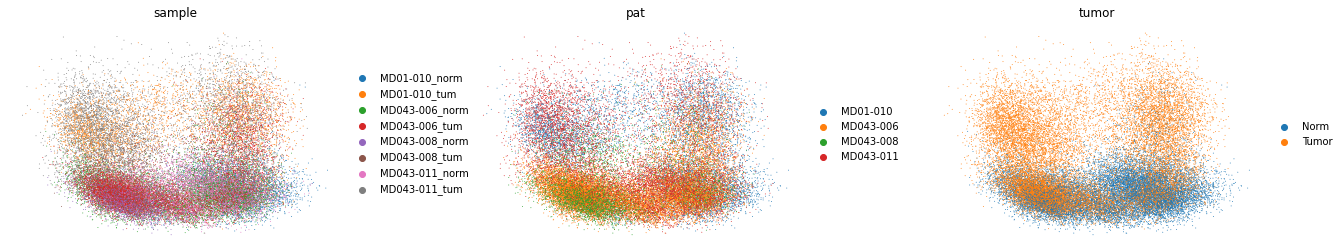

In [39]:
sc.tl.pca(adata_filtered) 
sc.pl.pca(adata_filtered, frameon=False, color=['sample', 'pat', 'tumor'], wspace=.25) 

## UMAP

Computing the neighborhood graph and embedding it in two dimensions using UMAP helps to visualize data sctructure

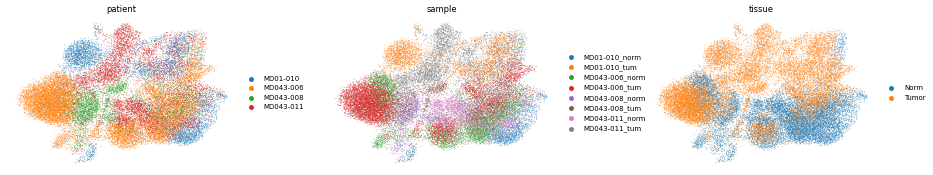

In [57]:
sc.pp.neighbors(adata_filtered, n_neighbors=18) 
sc.tl.umap(adata_filtered, min_dist=1) 
sc.pl.umap(adata_filtered, color=['patient', 'sample', 'tissue'], ncols=3, show=True, wspace=.25, frameon=False);
plt.show()

UMAP shows that data clusterizes by patients. The batch effect needs to be tackled

## Batch correction

We will use Harmony to remove technical batches between samples. 

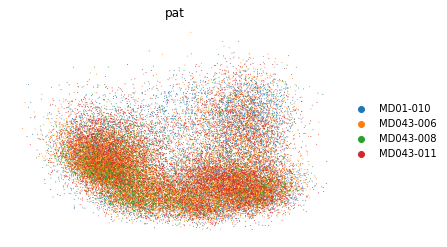

In [34]:
sce.pp.harmony_integrate(adata_filtered, key='pat')
sc.pl.embedding(adata_filtered, basis='X_pca_harmony', color='pat',frameon=False)

After harmonization, cell clusters are more evenly distributed among patients, however, the biological difference of the tumor/normal immune environment is not lost

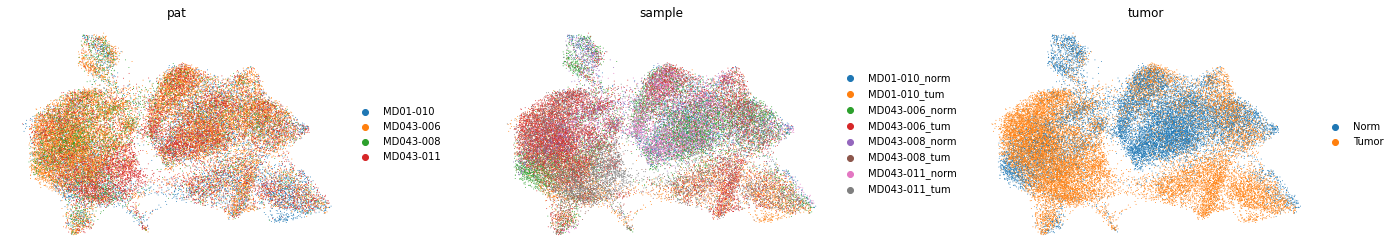

In [41]:
sc.pp.neighbors(adata_filtered, n_neighbors=20, use_rep='X_pca_harmony') 
sc.tl.umap(adata_filtered, min_dist=.6) 

sc.pl.umap(adata_filtered, color=['pat', 'sample', 'tumor'], frameon=False, ncols=3, wspace=.3);

## Clustering and annotation

Here I clusterize T cells and annotate them in accordance to cell specific markers.

In [62]:
sc.tl.leiden(adata_filtered, resolution=.9)
adata_filtered.obs.leiden.nunique()

12

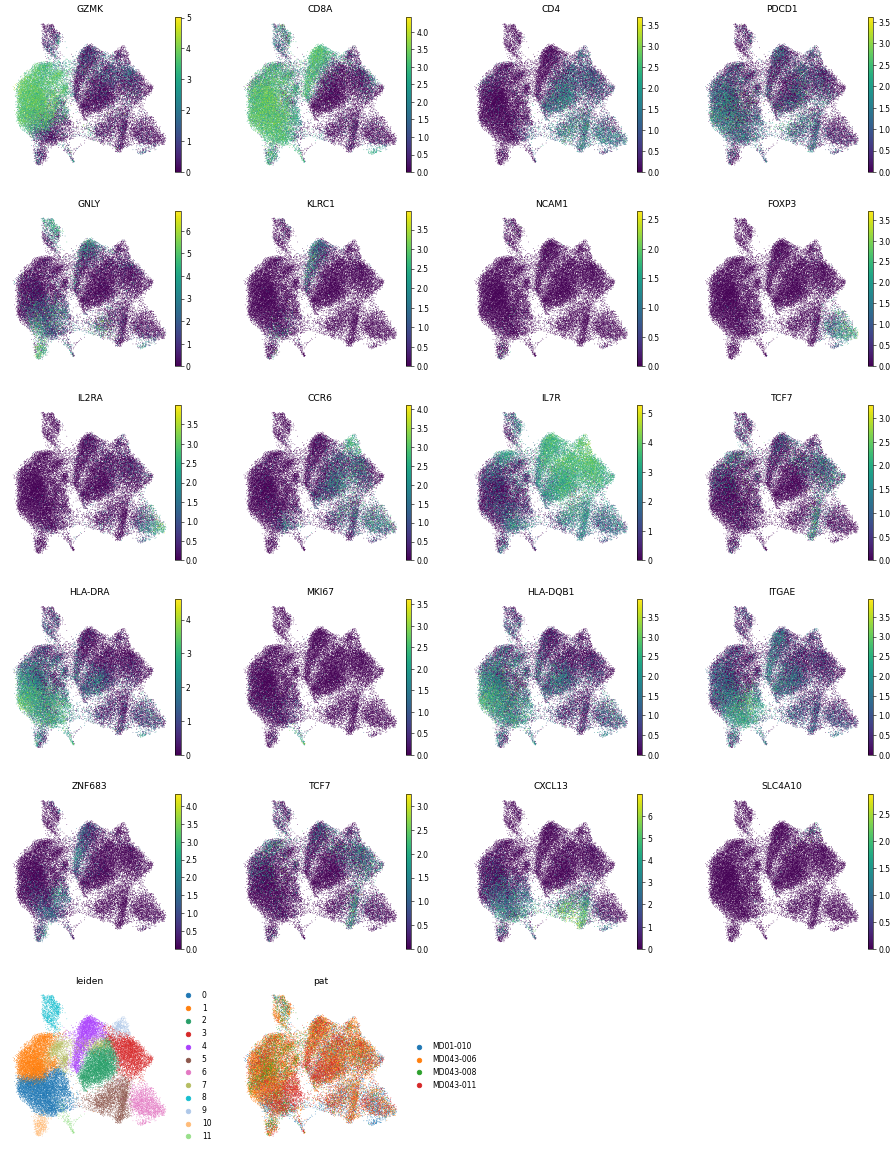

In [66]:
with plt.rc_context({"figure.figsize": (4, 4), "figure.dpi": (55)}):
    sc.pl.umap(adata_filtered, color=['GZMK', 'CD8A', 'CD4', 'PDCD1', 'GNLY', 'KLRC1', 'NCAM1',
                                      'FOXP3','IL2RA', 'CCR6', 'IL7R', 'TCF7', 'HLA-DRA', 'MKI67', 'HLA-DQB1',
                                      'ITGAE', 'ZNF683', 'TCF7', 'CXCL13', 'SLC4A10',
                                      'leiden', 'pat'],
               show=True, ncols=4, wspace=.25, use_raw=True, frameon=False);

Leiden clustering resulted in 12 separate clusters, that were annotated using combination of general CD4/CD8 markers with common subset specific markers:

* *FOXP3* for Tregs;

* *MKI67* for proliferating cells;

* *CXCL13* for Follicular helpers;

* *GZMA*, *GZMB*, *GZMK* for effector cells;

* *ZNF683* and *ITGAE* for memory cells;

* *KLRC1* for NK cells;

* *SLC4A10* for MAIT cells

In [69]:
genes = '''EOMES GZMK CRTAM NKG7 GNLY S1PR5 LINC02446 ZNF683 ITGAE STMN1 TUBB MKI67 
           HLA-DRA HLA-DQA1 HLA-DQB1 CCR6 IL4I1 SLC4A10 SELL CCR7 TCF7 IL7R GPR183 
           CD40LG PLIN2 CXCR6 ALOX5AP MT1X MT1E S100A11 CXCL13 FAAH2 NR3C1 MAF PTPN13
           KLRB1 FOXP3 CCR8 IL2RA'''.split()

In [77]:
leiden2celltype = {
    '0': 'CD8-mem1',
    '1': 'CD8-eff2',
    '2': 'CD4-helper1',
    '3': 'CD4-helper2',
    '4': 'CD8-NK',
    '5': 'CD4-f. helper',
    '6': 'CD4-T reg',
    '7': 'CD8-eff3',
    '8': 'CD8-eff1',
    '9': 'MAIT',
    '10': 'CD8-mem2',
    '11': 'CD8-proliferating',
    '12': 'CD8-eff3'
}

adata_filtered.obs['Cell_type'] = adata_filtered.obs['leiden'].map(leiden2celltype).astype('category')

Differentially expressed genes between our clusters:

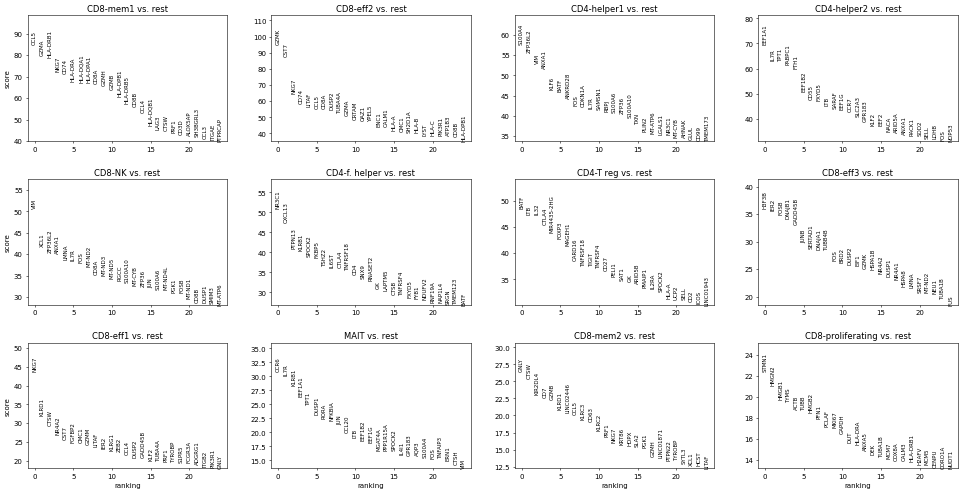

In [78]:
# adata_filtered.uns['log1p']["base"] = None ## this line should be used as a fix up if AnnData object has been loaded from .h5ad file
sc.tl.rank_genes_groups(adata_filtered, 'Cell_type', method='wilcoxon')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

In [79]:
top_genes = pd.DataFrame(adata_filtered.uns['rank_genes_groups']['names'])

In [80]:
top_genes.head(3)

CD8-mem1 CD8-eff2 CD4-helper1 CD4-helper2   CD8-NK CD4-f. helper CD4-T reg  \
0      CCL5     GZMK      S100A4      EEF1A1      VIM         NR3C1      BATF   
1      GZMA     CST7     ZFP36L2        IL7R     XCL1        CXCL13       LTB   
2  HLA-DRB1     NKG7         VIM        TPT1  ZFP36L2        PTPN13      IL32   

  CD8-eff3 CD8-eff1   MAIT CD8-mem2 CD8-proliferating  
0    H3F3B     NKG7   CCR6     GNLY             STMN1  
1     IER2    KLRD1   IL7R     CTSW             HMGN2  
2     FOSB     CTSW  KLRB1  KIR2DL4             HMGB1

Combining genes into sets for better visualisation

In [81]:
marker_genes_dict = {'СD markers': ['CD4', 'CD8A'],
                     'Effector': ['GZMK', 'GZMA', 'NKG7', 'GZMB', 'GNLY', 'S1PR5'],
                     'NK': ['KLRC1'],
                     'Memory': ['LINC02446', 'ZNF683', 'ITGAE',],
                     'Proliferation': ['MKI67', 'TUBB', 'STMN1'],
                     'MAIT': ['CCR6', 'IL4I1', 'SLC4A10'],
                     'CD4-foll. helper': ['CXCL13'],
                     'CD4-helper': ['S100A11', 'IL7R', 'GPR183', 'PLIN2',
                                  'CXCR6', 'MT1X'],
                     'T-reg': ['FOXP3', 'CCR8','IL2RA'],
                     'Checkpoint': ['ENTPD1', 'CTLA4', 'TIMP3', 'TIGIT', 'ENTPD1', 'LAG3']
}

categories: CD8-mem1, CD8-eff2, CD4-helper1, etc.
var_group_labels: СD markers, Effector, NK, etc.


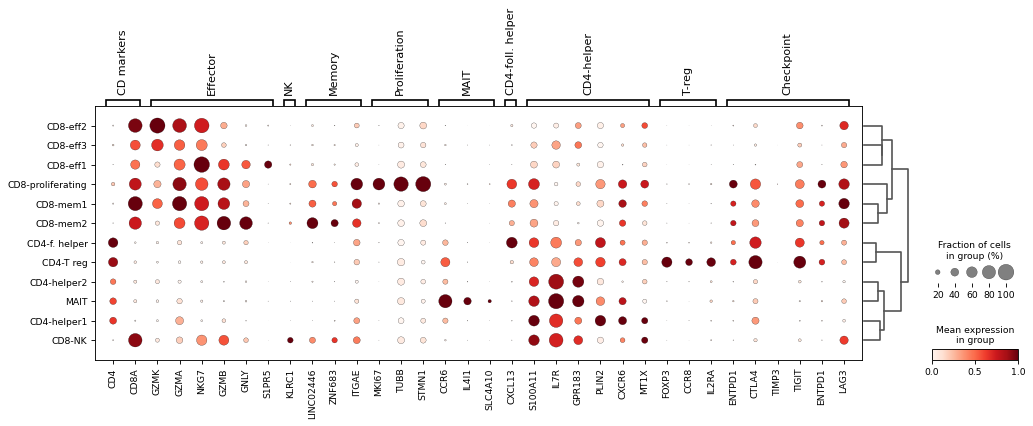

In [82]:
sc.tl.dendrogram(adata_filtered, groupby='Cell_type')
with plt.rc_context({"figure.dpi": (80)}):
    sc.pl.dotplot(adata_filtered, marker_genes_dict, groupby='Cell_type',
                  use_raw=False, dendrogram=True, swap_axes=False, 
                  standard_scale='var', vmin=0);

UMAP of clustering and cell annotation

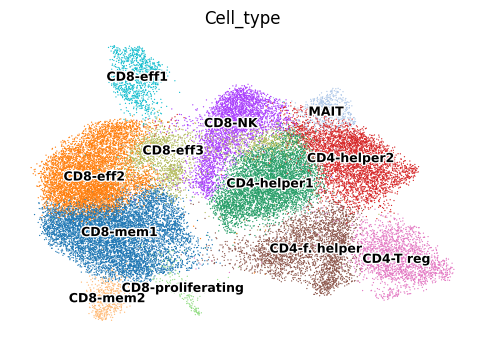

In [85]:
with plt.rc_context({"figure.dpi": (100)}):
    sc.pl.umap(adata_filtered, color=['Cell_type'], legend_loc='on data', 
               legend_fontoutline=2, legend_fontsize=9, show=True, frameon=False);

Let's compare cell type composition between types of tissue

In [46]:
adata_filtered.obs['Sample_type'] = adata_filtered.obs['tumor']
tumor_mask = adata_filtered.obs['Sample_type'] == 'Tumor'

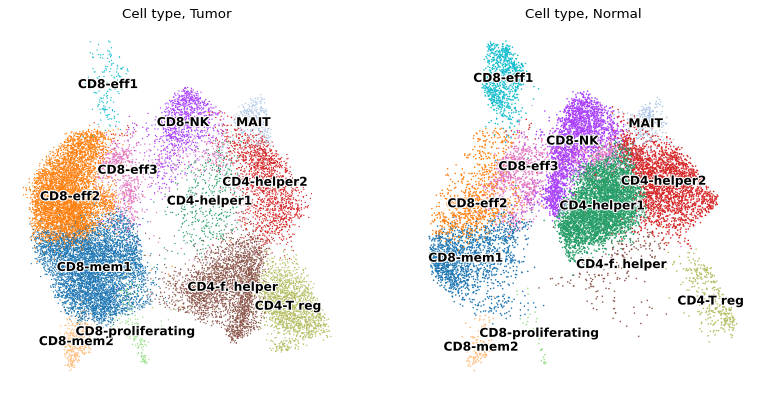

In [47]:
with plt.rc_context({"figure.dpi": (80)}):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

    sc.pl.umap(adata_filtered[tumor_mask], color=['Cell_type'], legend_loc='on data', 
               legend_fontoutline=2, legend_fontsize=11, ax=axs[0], frameon=False, show=False)
    axs[0].set_title('Cell type, Tumor')
    
    sc.pl.umap(adata_filtered[~tumor_mask], color=['Cell_type'], legend_loc='on data', 
               legend_fontoutline=2, legend_fontsize=11, ax=axs[1], frameon=False, show=False)
    axs[1].set_title('Cell type, Normal')

    plt.show()

> Tumor immune microenvironment is visibly enriched with CD8+ cells, namely CD8+ eff2 and mem1. It is also enriched in CD4+ Follicular helpers and T regs

> Normal immune microenvironment is enriched with CD4+ helpers and also with CD8+ eff1 CD8+ NK cells

In [95]:
geneset = marker_genes_dict['Checkpoint']
sc.tl.score_genes(adata_filtered, gene_list=geneset, score_name='Checkpoint',
                     use_raw=True)

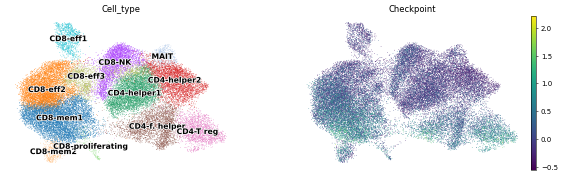

In [96]:
sc.pl.umap(adata_filtered, color=['Cell_type', 'Checkpoint'], legend_loc='on data', frameon=False,
           legend_fontoutline=2, legend_fontsize=11, show=True);

We can also look for differentially expressed genes between responders and non-responders to anti-PD-1 therapy

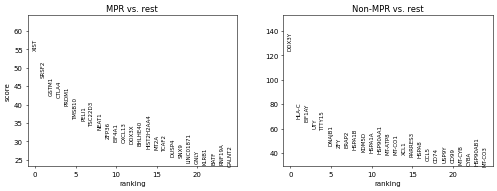

In [97]:
sc.tl.rank_genes_groups(adata_filtered, 'response_status', method='t-test')
sc.pl.rank_genes_groups(adata_filtered, n_genes=25, sharey=False)

# TCR seq

Now we load the paired TCR sequencing data, which to be merged with RNA seq results that we have prepared in the previous section

## TCR concatenation

In [103]:
import scirpy 

dirs = ! ls -d */ | grep 'vdj'
vdjs = []

for path in dirs:
    filepath = '/'.join((path, 'filtered_contig_annotations.csv'))
    vdj = scirpy.io.read_10x_vdj(filepath)
    vdj.obs['batch_name'] = path.split('.')[0]
    vdjs.append(vdj)

adata_vdj = vdjs[0].concatenate(vdjs[1:])

## TCRseq + RNAseq merge

In [105]:
adata_vdj.obs['batch'] = adata_vdj.obs['batch_name'].apply(lambda x: x[:-4]).astype(str)
adata_filtered.obs['batch'] = adata_filtered.obs['sample']

Check if our batch labels are correctly alligned

In [106]:
adata_vdj.obs['batch'].unique() == adata_filtered.obs['batch'].unique()

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [107]:
adata_filtered.shape, adata_vdj.shape

((35385, 3000), (35726, 0))

In [108]:
scirpy.pp.merge_with_ir(adata_filtered, adata_vdj, on=['batch'])

In [109]:
adata_filtered.shape

(35385, 3000)

In [110]:
adata_filtered.obs['has_ir'] = adata_filtered.obs['has_ir'].map({'True': True, 'None': False})
adata_filtered.obs['has_ir'].value_counts()

True     29607
False     5778
Name: has_ir, dtype: int64

Exploration of an ammound of matched cells

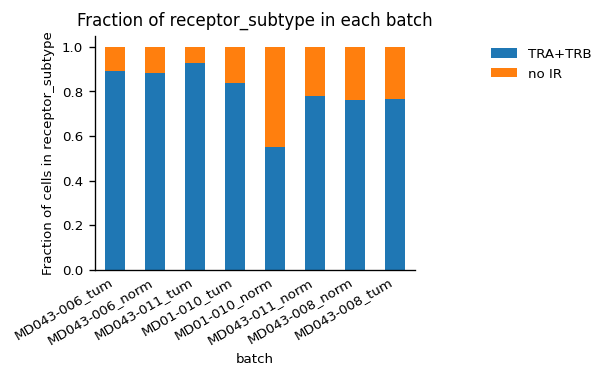

In [111]:
import scirpy as ir
ir.tl.chain_qc(adata_filtered)

ax = ir.pl.group_abundance(adata_filtered, groupby="batch", target_col="receptor_subtype", normalize=True)

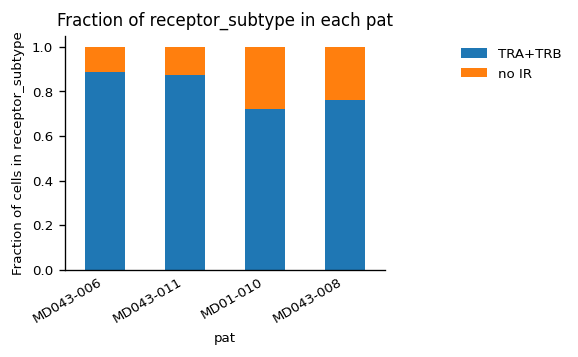

In [112]:
ax = ir.pl.group_abundance(adata_filtered, groupby="pat", target_col="receptor_subtype", normalize=True)

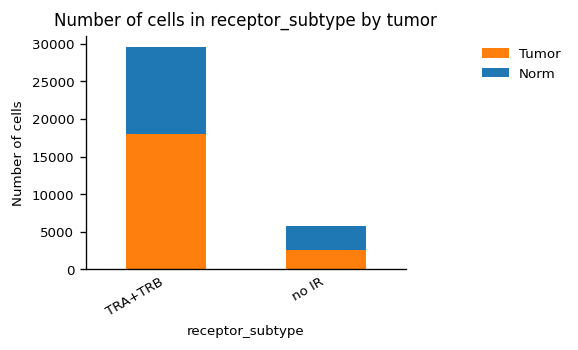

In [113]:
ax = ir.pl.group_abundance(adata_filtered, groupby="receptor_subtype", target_col="tumor")

In [114]:
adata_filtered.obs.groupby('sample')['has_ir'].value_counts()

sample          has_ir
MD01-010_norm   True      1600
                False     1301
MD01-010_tum    True      3655
                False      718
MD043-006_norm  True      6221
                False      828
MD043-006_tum   True      8585
                False     1048
MD043-008_norm  True      1620
                False      510
MD043-008_tum   True      1331
                False      404
MD043-011_norm  True      2199
                False      617
MD043-011_tum   True      4396
                False      352
Name: has_ir, dtype: int64

## TCR analysis

There we will explore the clonal composition of T cells separatelly in Tumor and Normal tissues. We also gonna broadly divide lymphocyte into CD8+ and CD4+ subtypes to assess the differences between them

In [115]:
def plot_pair(pl, adata, mask, labels, **kwargs):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7), sharey=False)

    pl(adata[mask], **kwargs, ax=axs[0])
    pl(adata[~mask], **kwargs, ax=axs[1])
    
    title = axs[0].title._text+'\n'
    
    axs[0].set_title(labels[0])
    axs[1].set_title(labels[1])
    
    plt.suptitle(title)

In [120]:
adata_filtered.obs['T_Cell_type'] = adata_filtered.obs.Cell_type.apply(lambda x: 'CD8+' if 'CD8' in x else 'CD4+')

In [119]:
cd4_mask = adata_filtered.obs['T_Cell_type'] == 'CD4+'

### Chain pairing

While most of T cell receptors have exactly one pair of α and β chains, up to one third of T cells can have dual TCRs, i.e. two pairs of receptors originating from different alleles. We will now visualize  Immune cell-receptor compositions. 

Chain pairing:

* Orphan chain refers to cells that have either a single alpha or beta receptor chain.
* Extra chain refers to cells that have a full alpha/beta receptor pair, and an additional chain.
* Multichain refers to cells with more than two receptor pairs detected. These cells are likely doublets.


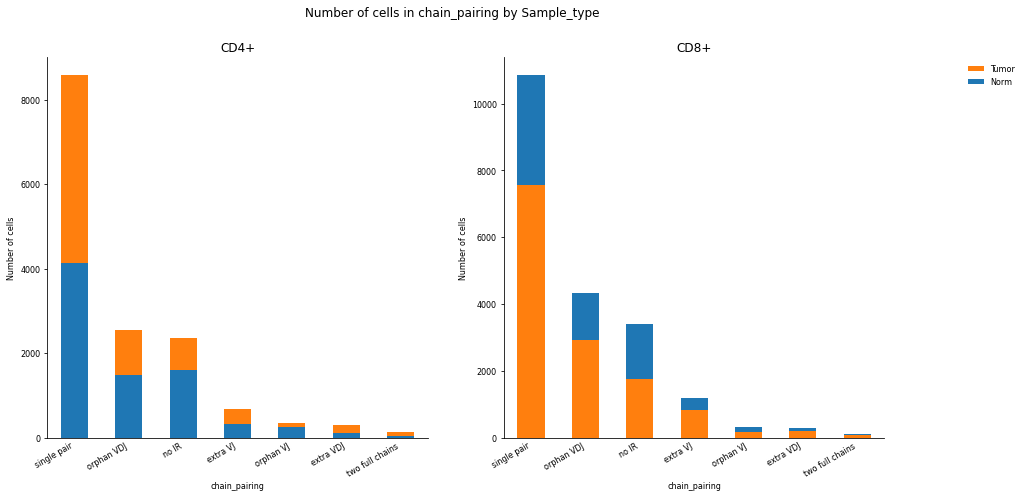

In [120]:
args = "chain_pairing", "tumor"
kwargs = {'groupby': "chain_pairing", 'target_col': "Sample_type"}
labels=['CD4+', 'CD8+']

plot_pair(ir.pl.group_abundance, adata_filtered, cd4_mask, labels,
          **kwargs)

In [123]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            adata_filtered.obs["chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains"]
            )
        )
        / adata_filtered.n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.07


In this dataset, ~7% of cells have more than one pair of productive T-cell receptors and we can visualize them on our UMAP

In [124]:
adata_filtered.obs['chain_pairing'].value_counts()

single pair        19445
orphan VDJ          6864
no IR               5778
extra VJ            1847
orphan VJ            659
extra VDJ            561
two full chains      231
Name: chain_pairing, dtype: int64

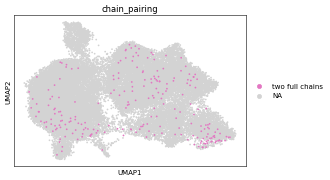

In [125]:
sc.pl.umap(adata_filtered, color="chain_pairing", groups="two full chains", size=25)

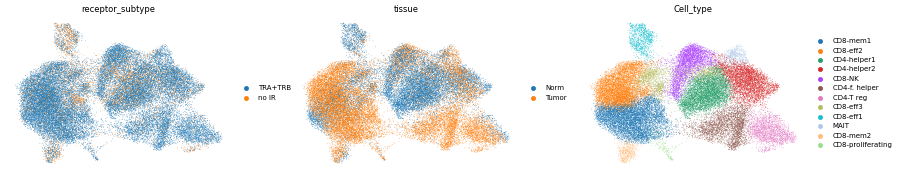

In [150]:
sc.pl.umap(adata_filtered, color=['receptor_subtype', 'tissue', 'Cell_type'], wspace=.15, frameon=False)

In [127]:
batch2perc = dict()
for sample in adata_filtered.obs['batch'].unique():
    vc = adata_filtered[adata_filtered.obs['batch'] == sample].obs['receptor_type'].value_counts()
    try:
        batch2perc[sample] = vc.loc['TCR'] / vc.sum()
    except:
        batch2perc[sample] = 0.01
batch2perc

{'MD01-010_norm': 0.5515339538090314,
 'MD01-010_tum': 0.8358106563000228,
 'MD043-006_norm': 0.8825365300042559,
 'MD043-006_tum': 0.8912073082113567,
 'MD043-008_norm': 0.7605633802816901,
 'MD043-008_tum': 0.7671469740634006,
 'MD043-011_norm': 0.7808948863636364,
 'MD043-011_tum': 0.9258635214827295}

<AxesSubplot:>

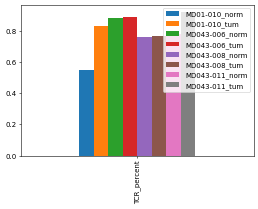

In [128]:
pd.DataFrame(batch2perc, index=['TCR_percent']).plot.bar()

### Clonotype network

Now we will compute  distances between CDR3 amino acid (aa) sequences, either based on sequence similarity for all unique VJ sequences and for all unique VDJ sequences. The distance matrices then will be used to construct TCR clonotypes in clonotype networks.

In [129]:
ir.pp.ir_dist(adata_filtered)
ir.tl.define_clonotypes(adata_filtered, receptor_arms="all", dual_ir="primary_only")

  0%|          | 0/12817 [00:00<?, ?it/s]

In [130]:
ir.tl.clonotype_network(adata_filtered, min_cells=2)

In [131]:
ir.pp.ir_dist(
    adata_filtered,
    metric="alignment",
    sequence="aa",
    cutoff=10,
)

  0%|          | 0/18528 [00:00<?, ?it/s]

  0%|          | 0/24090 [00:00<?, ?it/s]

In [132]:
ir.tl.define_clonotype_clusters(
    adata_filtered, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

  0%|          | 0/13292 [00:00<?, ?it/s]

In [133]:
ir.tl.clonotype_network(adata_filtered, min_cells=12, sequence="aa", metric="alignment")

Construction of a clonotype network by computing distances between CDR3 sequences reveals a set of public clonotypes - clonotype clusters shared by all of the patients, illustrating possible specificity to a common pathogen (the clonotype network has been defined through amino acid alignment with distance based on BLOSUM62 matrix. Two clonotypes were connected in the network with distance of their CDR3 lower than 10). 

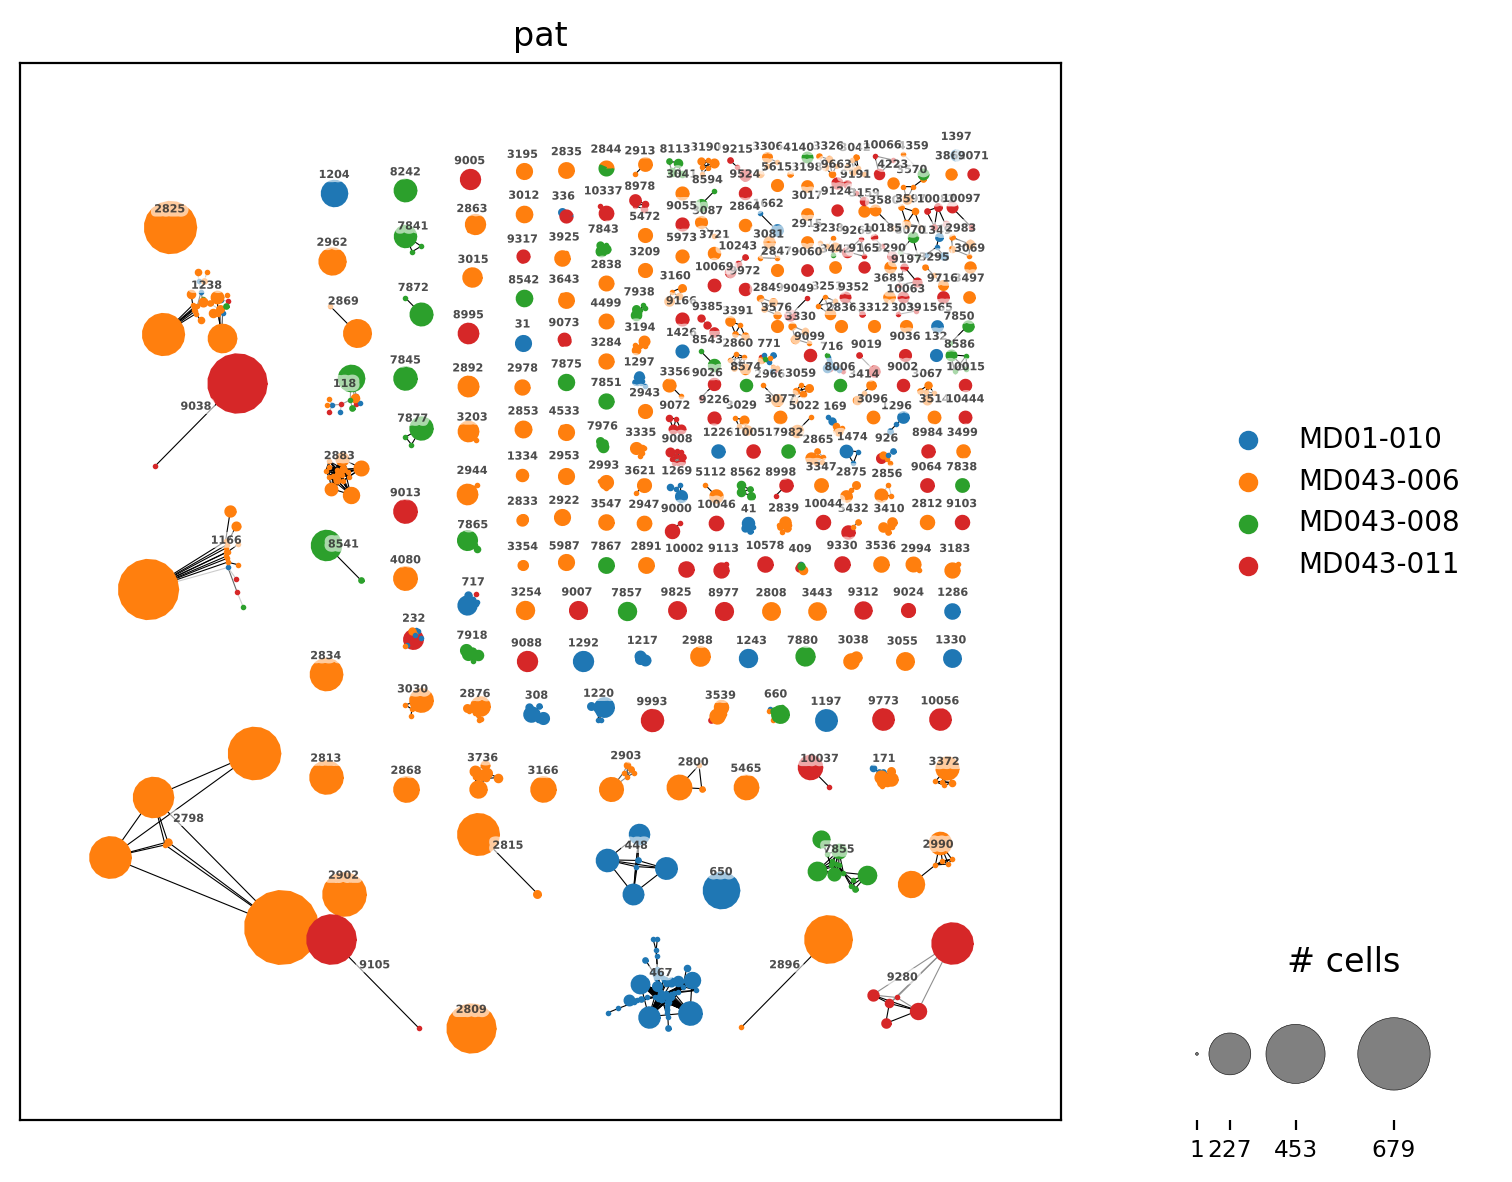

In [135]:
with plt.rc_context({"figure.dpi": (200)}):
    ir.pl.clonotype_network(
        adata_filtered, color="pat", label_fontsize=4, panel_size=(7, 7), base_size=1
    )

We see a huge clonotype cluster that is **not patient specific**! That illustrates a possible specificity to a common pathogen

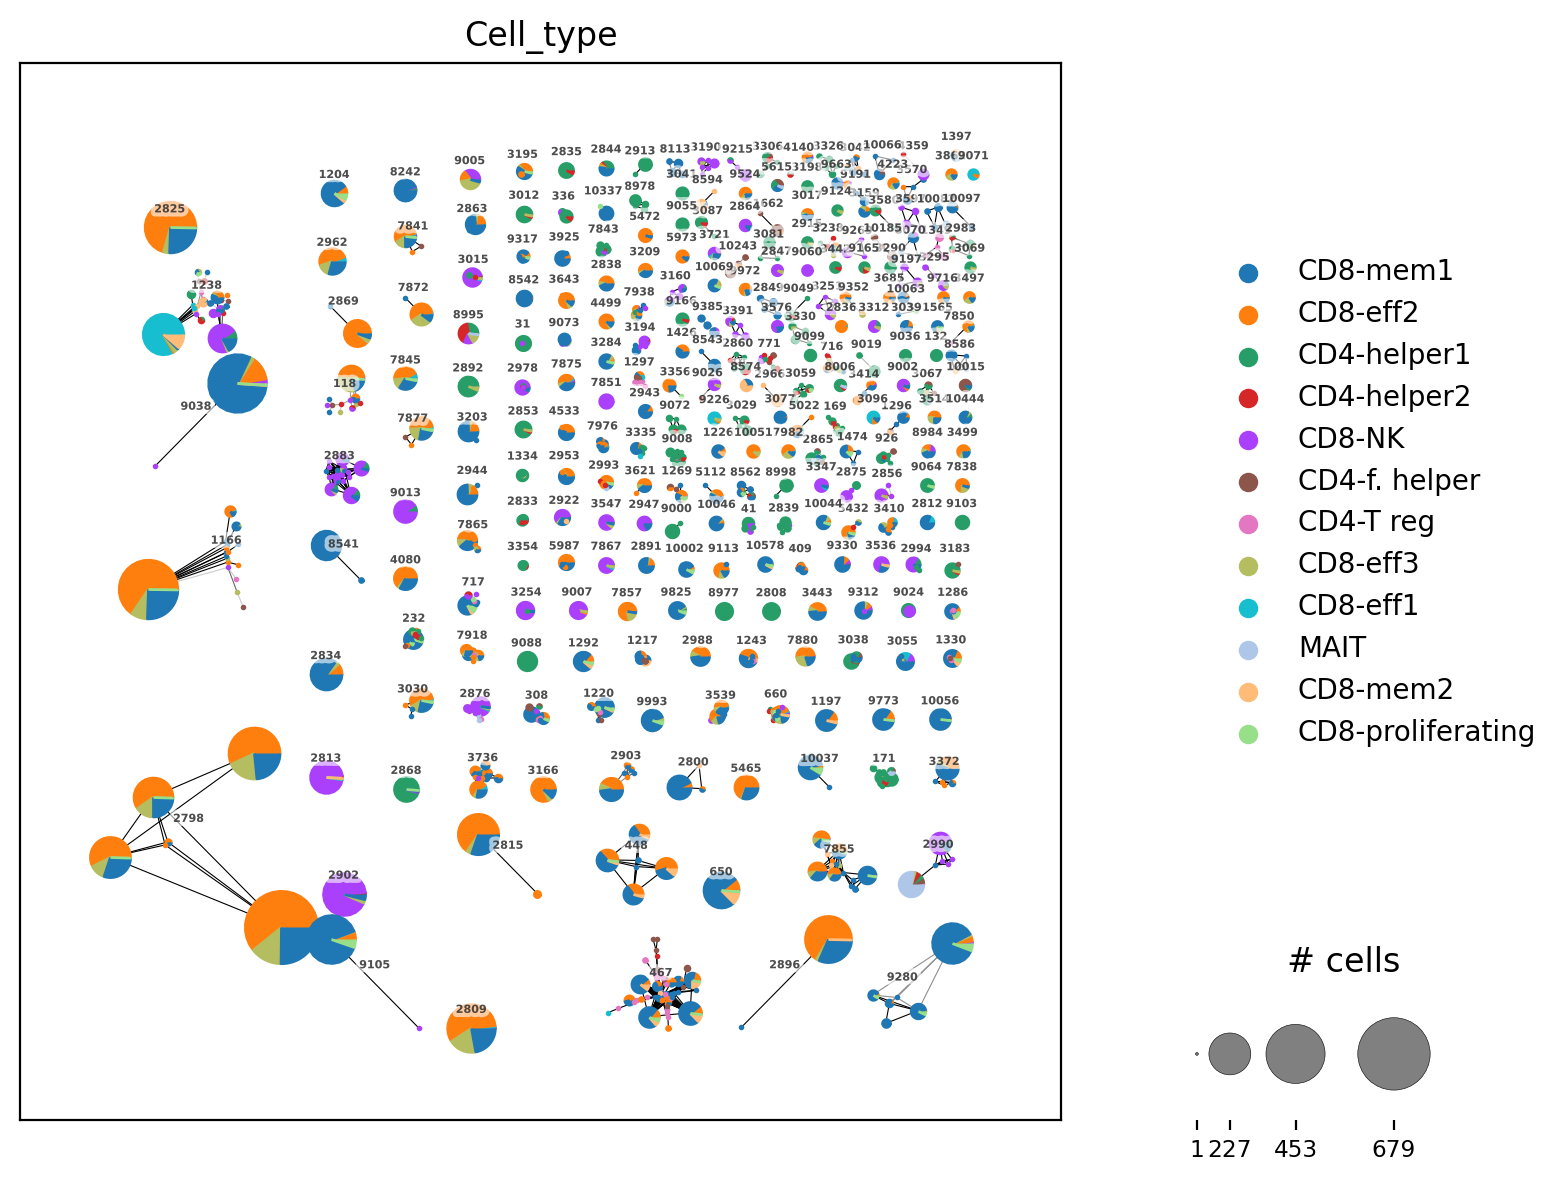

In [134]:
with plt.rc_context({"figure.dpi": (200)}):
    ir.pl.clonotype_network(
        adata_filtered, color="Cell_type", label_fontsize=4, panel_size=(7, 7), base_size=1
    )

### Clonal expansion

Let’s visualize the number of expanded clonotypes (i.e. clonotypes consisting of more than one cell) by cell-type

Text(0.5, 0.98, 'Clonal expansion')

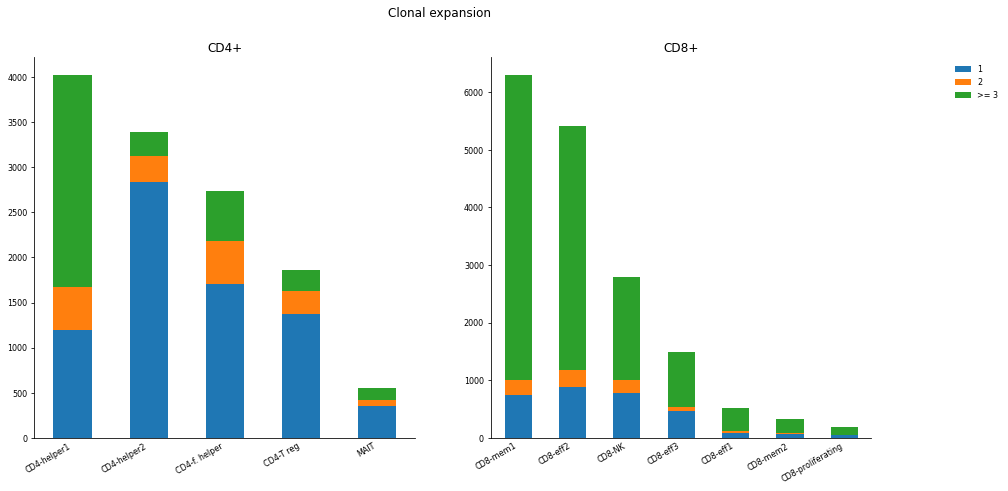

In [341]:
kwargs = {'groupby': 'Cell_type', 'clip_at': 3, 'normalize': False}
labels=['CD4+', 'CD8+']

plot_pair(ir.pl.clonal_expansion, adata_filtered, cd4_mask, labels,
          **kwargs)
plt.suptitle('Clonal expansion')

Text(0.5, 0.98, 'Clonal expansion')

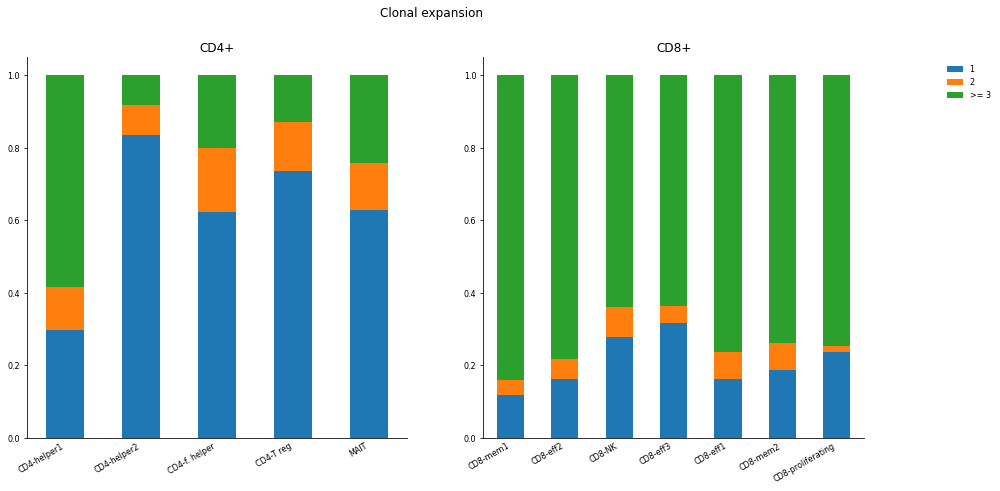

In [343]:
kwargs = {'groupby': "Cell_type", 'clip_at': 3, 'normalize': True}

plot_pair(ir.pl.clonal_expansion, adata_filtered, cd4_mask, labels,
          **kwargs)
plt.suptitle('Clonal expansion');

CD8+ T-cells (namely mem1&2, eff1&2) have a large fraction of expanded clonotypes

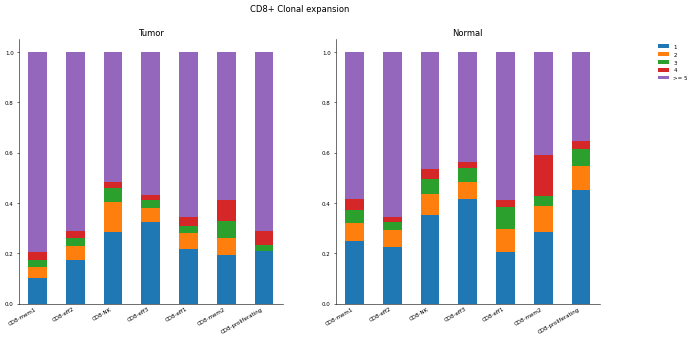

In [215]:
kwargs = {'groupby': "Cell_type", 'clip_at': 5, 'normalize': True}

tum_mask = adata_filtered[~cd4_mask].obs.tissue == 'Tumor'

plot_pair(ir.pl.clonal_expansion, adata_filtered[~cd4_mask], tum_mask, labels=['Tumor', 'Normal'],
          **kwargs)
plt.suptitle('CD8+ Clonal expansion');

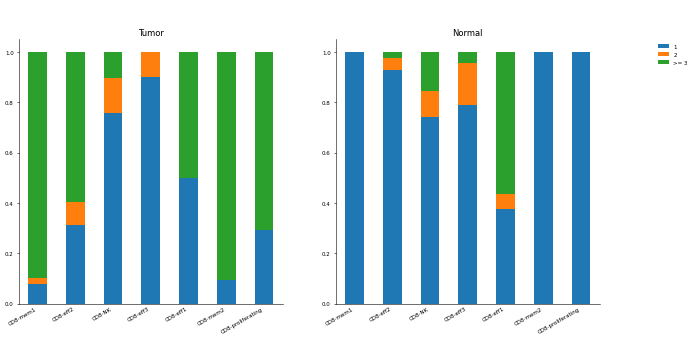

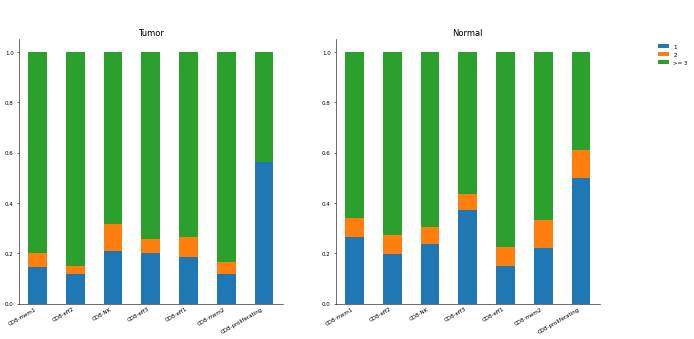

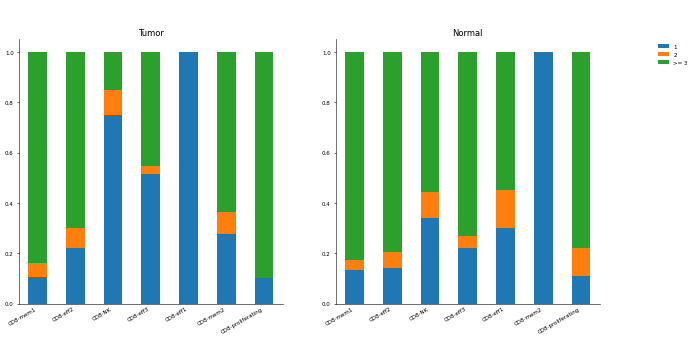

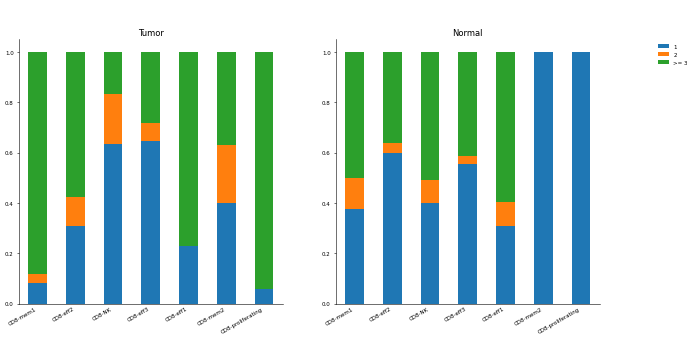

In [218]:
kwargs = {'groupby': "Cell_type", 'clip_at': 3, 'normalize': True}
adata_slice = adata_filtered[~cd4_mask]

for pat in adata_filtered.obs.pat.unique():
    pat_mask = adata_slice.obs.pat == pat
    pat_tum_mask = adata_slice[pat_mask].obs.tissue == 'Tumor'
    
    plot_pair(ir.pl.clonal_expansion, adata_slice[pat_mask], pat_tum_mask, ['Tumor', 'Normal'],
              **kwargs)

### TCR diversity

Consistent with this observation, they have the lowest `alpha_diversity` of clonotypes.

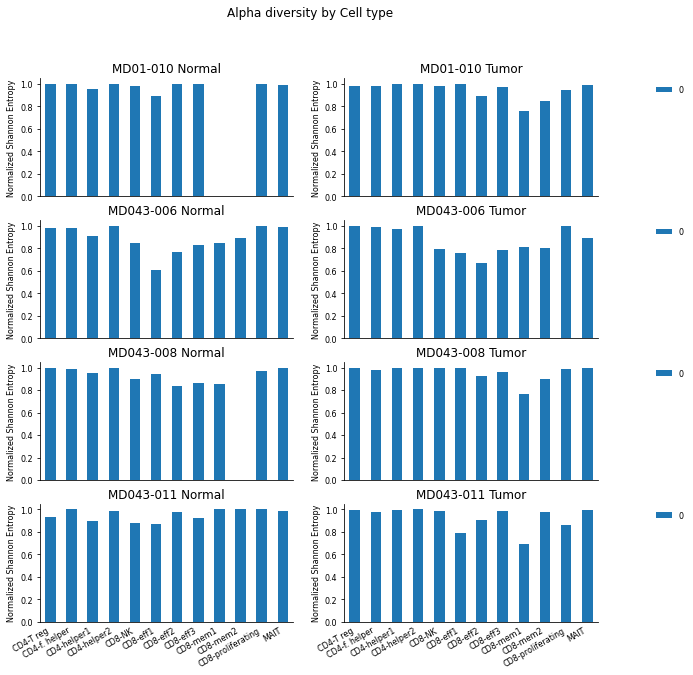

In [335]:
fig, axs = plt.subplots(ncols=2, nrows=adata_filtered.obs.pat.nunique(), figsize=(10, 10), squeeze=False, sharex=True) 

for i, pat in enumerate(adata_filtered.obs.pat.unique()):
    adata = adata_filtered[adata_filtered.obs.pat == pat]
    
    adata_n = adata[adata.obs['tumor'] == 'Norm']
    ir.tl.alpha_diversity(adata_n, groupby='Cell_type')
    ir.pl.alpha_diversity(adata_n, groupby='Cell_type', ax=axs[i][0])
    axs[i][0].set_title(pat+' Normal')

    
    adata_t = adata[adata.obs['tumor'] != 'Norm']
    ir.tl.alpha_diversity(adata_t, groupby='Cell_type')
    ir.pl.alpha_diversity(adata_t, groupby='Cell_type', ax=axs[i][1])
    axs[i][1].set_title(pat+' Tumor')
    
plt.suptitle('Alpha diversity by Cell type')
plt.show()

> CD8 memory cells are sometimes completely absent in normal cells, that may be due to the low population of that cells in normal tissue and lack of sequencing outputs for them

### Clonotype abundance

Lets plot the distribution of the ten largest clonotypes across patients, tissue and the cell-type clusters

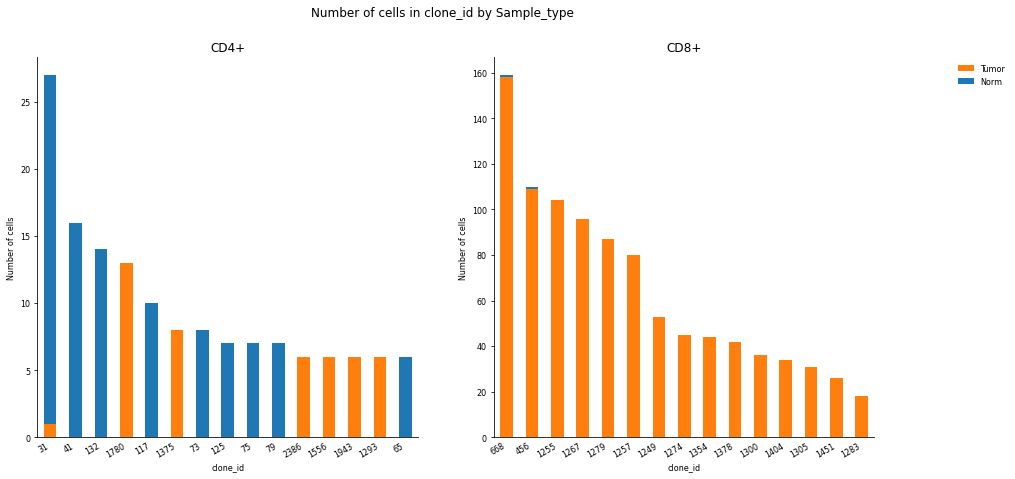

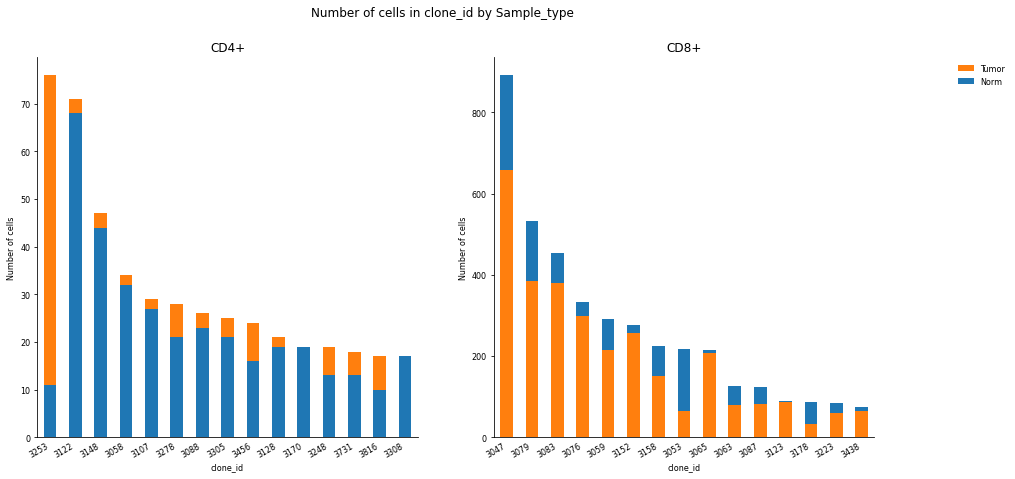

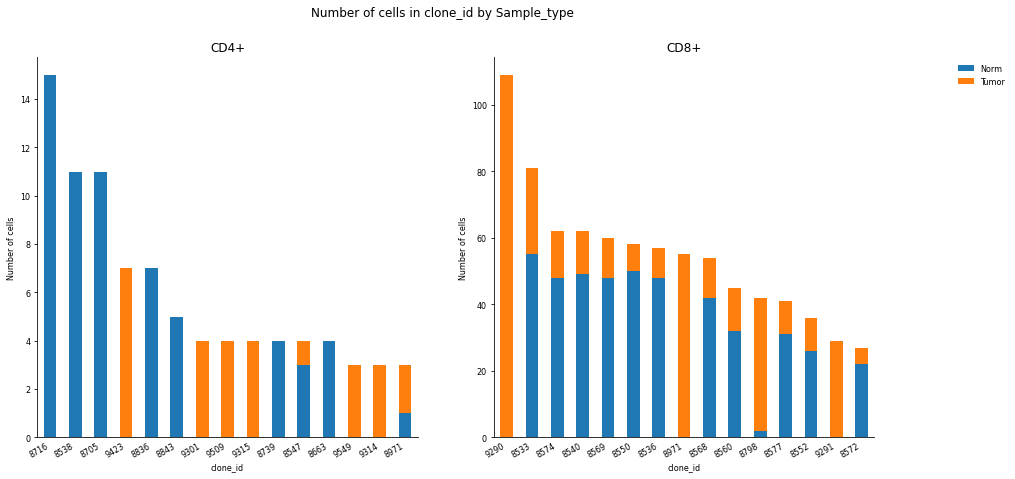

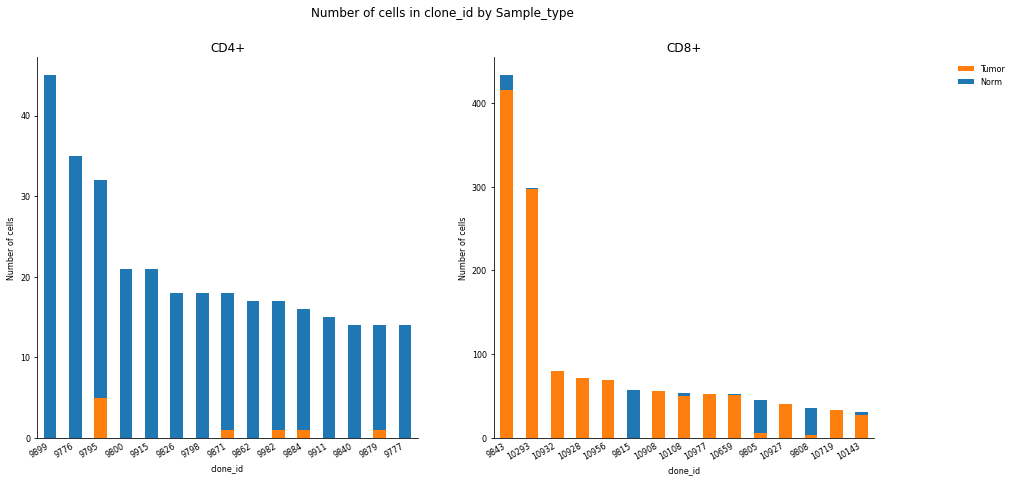

In [344]:
kwargs = {'groupby': "clone_id",  'target_col': "Sample_type", 'max_cols': 15}

adata_filtered.obs['cd4_mask'] = cd4_mask
for pat in adata_filtered.obs.pat.unique():
    pat_mask = adata_filtered.obs.pat == pat
    cd4_pat_mask = adata_filtered[pat_mask].obs.cd4_mask
    plot_pair(ir.pl.group_abundance, adata_filtered[pat_mask], cd4_pat_mask, labels,
              **kwargs)

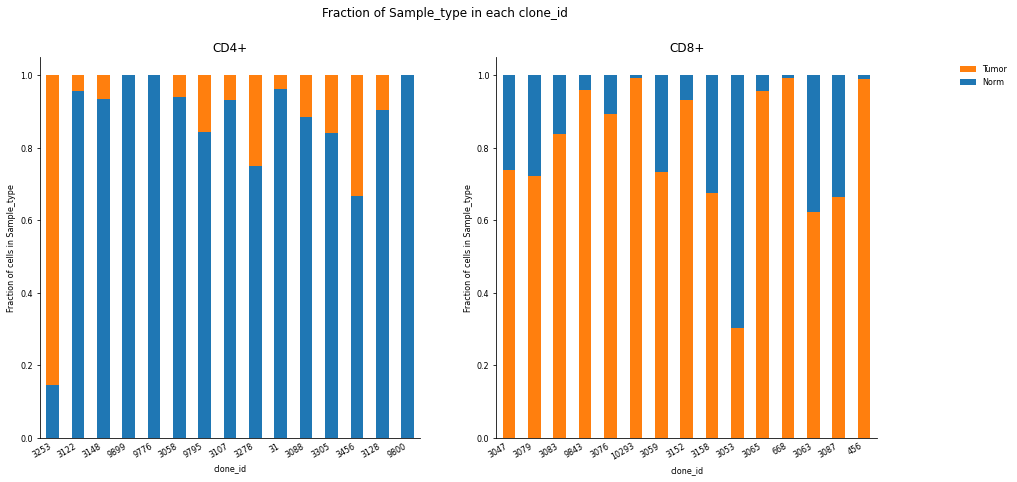

In [345]:
kwargs = {'groupby': "clone_id",  'target_col': "Sample_type", 'max_cols': 15, 'normalize': True}

plot_pair(ir.pl.group_abundance, adata_filtered, cd4_mask, labels,
          **kwargs)

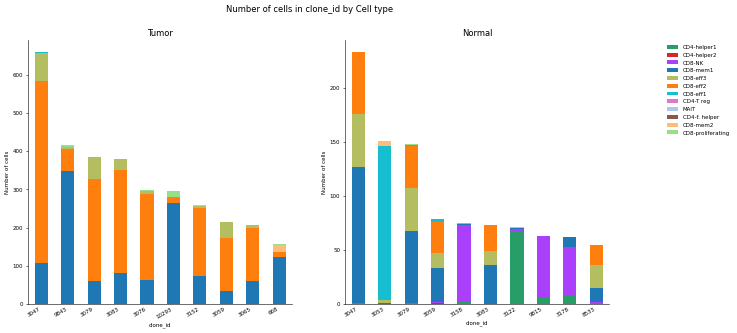

In [240]:
kwargs = {'groupby': "clone_id", 'target_col': "Cell_type", 'max_cols': 10}

tum_mask = adata_filtered.obs.tissue == 'Tumor'

plot_pair(ir.pl.group_abundance, adata_filtered, tum_mask, labels=['Tumor', 'Normal'],
          **kwargs)
plt.suptitle('Number of cells in clone_id by Cell type');

Exploring the largest subclones, we note that **Tumor and Normal samples do not share cellular compositions**, with Normal composition being highly more variable. As tumor immunity is occupied with its fight with malignant cells, there are less expanded clonotypes with cells being specific to other pathogenic species.

### VDJdb

Here we assemble query to VDJdb (Shugay M., et al. 2018) - a manualy curated immunological database - to explore antigen specificity by TCR sequence. We will extract source of pathogenis species that are the sources of annotated antigens

In [192]:
vdjdb = ir.datasets.vdjdb()

In [193]:
ir.pp.ir_dist(adata_filtered, vdjdb, metric="identity", sequence="aa")

In [194]:
ir.tl.ir_query(
    adata_filtered, vdjdb, metric="identity", sequence="aa", receptor_arms="any", dual_ir="any"
)

  0%|          | 0/13292 [00:00<?, ?it/s]

In [195]:
ir.tl.ir_query_annotate(
    adata_filtered,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species"],
    strategy="most-frequent",
)

  0%|          | 0/3766 [00:00<?, ?it/s]

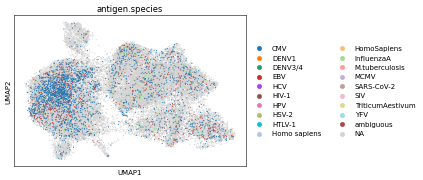

In [196]:
sc.pl.umap(adata_filtered, color="antigen.species", size=10)

In [197]:
lung_pathogens = ['InfluenzaA', 'SARS-CoV-2', 'M.tuberculosis']
lung_pathogen_mask = adata_filtered.obs['antigen.species'].isin(lung_pathogens)

 query to VDJdb showed that proportion of CD8+ TCRs specific to common lung pathogens (*InfluenzaA*, *SARS-CoV-2*, *M.tuberculosis*) was **1.4 fold higher in normal subset (1.53% vs 1.11%)**:

In [199]:
len(adata_filtered[lung_pathogen_mask & ~tumor_mask & ~cd4_mask]) / (~tumor_mask  & ~cd4_mask).sum()

0.01513420902341519

In [200]:
len(adata_filtered[lung_pathogen_mask & tumor_mask & ~cd4_mask]) / (tumor_mask  & ~cd4_mask).sum()

0.01110042181602901

CMV is the most common source of antigens

In [203]:
adata_filtered.obs['antigen.species'].value_counts()

CMV                 2531
ambiguous            338
InfluenzaA           293
EBV                  235
SARS-CoV-2           212
HomoSapiens           72
YFV                   29
HIV-1                 20
HCV                   17
HSV-2                  4
DENV1                  3
MCMV                   2
DENV3/4                2
M.tuberculosis         2
HTLV-1                 2
SIV                    1
TriticumAestivum       1
HPV                    1
Homo sapiens           1
Name: antigen.species, dtype: int64

Let's see the composition of pathogenic specificity in different patients

In [166]:
vc = adata_filtered.obs.groupby('pat')['antigen.species'].value_counts()
pathogen_table = vc[vc > 1] / vc[vc > 1].sum()
pathogen_table = pathogen_table.unstack(level=1).fillna(0)

In [167]:
table.unstack(level=1).fillna(0)

CMV  ambiguous  InfluenzaA       EBV  SARS-CoV-2  HomoSapiens  \
pat                                                                             
MD01-010   0.058871   0.013586    0.011188  0.010123    0.009323     0.003463   
MD043-006  0.429142   0.049547    0.037826  0.030368    0.034896     0.005328   
MD043-008  0.089238   0.013319    0.011454  0.009323    0.003996     0.001332   
MD043-011  0.096963   0.013586    0.017581  0.012786    0.008258     0.009057   

              HIV-1       HCV       YFV     HSV-2  M.tuberculosis     DENV1  
pat                                                                          
MD01-010   0.001332  0.000799  0.000533  0.000000        0.000000  0.000000  
MD043-006  0.002664  0.002664  0.006127  0.001066        0.000533  0.000000  
MD043-008  0.000000  0.000000  0.000533  0.000000        0.000000  0.000000  
MD043-011  0.001066  0.001066  0.000533  0.000000        0.000000  0.000533

<AxesSubplot:ylabel='pat'>

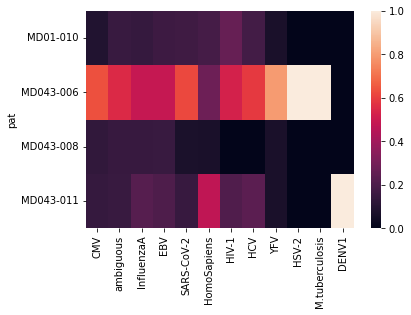

In [168]:
sns.heatmap(pathogen_table / pathogen_table.sum(axis=0))

We see that specificity to some pathogens like *InfluenzaA*, *EBV* and *SARS-CoV-2* are present in several patients. Specificity *M.tuberculosis*,  *HSV-2* and *DENV1* looks more uncommon and is found uniquely in one patient each. 

Let's now explore the specificity of a previously identified clonotype network that was shared across all the patients

In [206]:
pub_clone = adata_filtered.obs.loc[adata_filtered.obs["cc_aa_alignment"] == "1238", :]
pub_clone['antigen.species'].value_counts()

CMV                 8
ambiguous           1
DENV3/4             0
InfluenzaA          0
YFV                 0
TriticumAestivum    0
SIV                 0
SARS-CoV-2          0
MCMV                0
M.tuberculosis      0
HomoSapiens         0
EBV                 0
DENV1               0
HTLV-1              0
HSV-2               0
HPV                 0
HIV-1               0
HCV                 0
Homo sapiens        0
Name: antigen.species, dtype: int64

The query to VDJdb has shown that TCRs from clonotype network `1238` were indeed specific for antigens from single pathogenic species - CMV.

### Clonotype modularity

Using the Clonotype modularity we can identify clonotypes consisting of cells that are transcriptionally more similar than expected by random.

The clonotype modularity score represents the log2 fold change of the number of edges in the cell-cell neighborhood graph compared to the random background model. Clonotypes (or clonotype clusters) with a high modularity score consist of cells that have a similar molecular phenotype.

In [478]:
ir.tl.clonotype_modularity(adata_filtered, target_col="cc_aa_alignment")

  0%|          | 0/11778 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

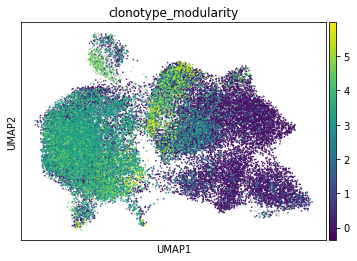

In [484]:
sc.pl.umap(adata_filtered, color="clonotype_modularity", size=10)

<AxesSubplot:>

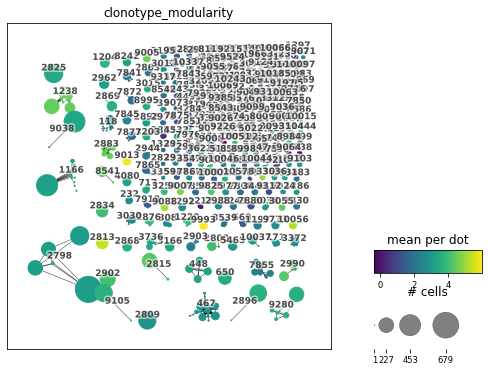

In [483]:
ir.pl.clonotype_network(
    adata_filtered,
    color="clonotype_modularity",
    label_fontsize=9,
    panel_size=(6, 6),
    base_size=1,
)

In [519]:
# # Saving the results!
# adata_filtered.write_h5ad('../adata_filtered_clean_tcr.h5ad')